**Contents**  
[Part I: Exploratory Data Analysis (EDA)](#Part-I:-Exploratory-Data-Analysis-(EDA))  
[Part 2: Spliting data](#Part-2:-Spliting-data)  
[Part 3. Data Engineering with Mxnet RecordIO format](#Part-3.-Data-Engineering-with-Mxnet-RecordIO-format)

### Extract zip files if needed  
(Use only at the first time)

In [6]:
import zipfile

extract_data = False # True
if extract_data:
    zip_file_paths = ['trainImages.zip', 'validationImages.zip'] 
    for file_path in zip_file_paths:
        name = str(file_path)
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(f'unzipped/{name.split(".")[0]}')

### Read train and validation dectections files

In [7]:
import pandas as pd
import os

root = 'unzipped/'
df_train = pd.read_csv(os.path.join(root, 'trainImages/labels/detections.csv'))
df_train.head()

ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  000002b66c9c498e  xclick  /m/01g317           1  0.012500  0.195312   
1  000002b66c9c498e  xclick  /m/01g317           1  0.025000  0.276563   
2  000002b66c9c498e  xclick  /m/01g317           1  0.151562  0.310937   
3  000002b66c9c498e  xclick  /m/01g317           1  0.256250  0.429688   
4  000002b66c9c498e  xclick  /m/01g317           1  0.257812  0.346875   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.148438  0.587500           0            1  ...            0         0   
1  0.714063  0.948438           0            1  ...            0         0   
2  0.198437  0.590625           1            0  ...            0         0   
3  0.651563  0.925000           1            0  ...            0         0   
4  0.235938  0.385938           1            0  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.148438  0.012500  0.059375  0.195312  0.148438  0.357812  0.587500   
1  0.025000  0.248438  0.276563  0.214062  0.914062  0.714063  0.782813   
2  0.243750  0.151562  0.310937  0.262500  0.198437  0.434375  0.507812   
3  0.315625  0.429688  0.256250  0.423438  0.651563  0.921875  0.826562   
4  0.317188  0.257812  0.346875  0.307812  0.235938  0.289062  0.348438   

   XClick4Y  
0  0.325000  
1  0.948438  
2  0.590625  
3  0.925000  
4  0.385938  

[5 rows x 21 columns]

In [8]:
df_train.shape  # ~ 14.6 million images with bounding boxes
                #  for all Open Images Dataset (not only Plastic bag)

(14610229, 21)

In [9]:
df_validation = pd.read_csv(os.path.join(root, 'validationImages/labels/detections.csv'))
df_validation.head()

ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0001eeaf4aed83f9  xclick  /m/0cmf2           1  0.022673  0.964201   
1  000595fe6fee6369  xclick  /m/02wbm           1  0.000000  1.000000   
2  000595fe6fee6369  xclick  /m/02xwb           1  0.141384  0.179676   
3  000595fe6fee6369  xclick  /m/02xwb           1  0.213549  0.253314   
4  000595fe6fee6369  xclick  /m/02xwb           1  0.232695  0.288660   

       YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
0  0.071038  0.800546           0            0          0            0   
1  0.000000  1.000000           0            0          1            0   
2  0.676275  0.731707           0            0          0            0   
3  0.299335  0.354767           1            0          0            0   
4  0.490022  0.545455           1            0          0            0   

   IsInside  
0         0  
1         0  
2         0  
3         0  
4         0

In [10]:
df_validation.shape

(303980, 13)

## Part I: Exploratory Data Analysis (EDA)

### Info of Plastic bag images

In [11]:
img_paths_train = os.path.join(root, 'trainImages/data/*.jpg')
img_paths_validation = os.path.join(root, 'validationImages/data/*.jpg')

#### Number of Plastic bag images

In [12]:
import glob # to recursively go folder
len(glob.glob(img_paths_train)) # 517 --> has only 517 Plastic bag images

517

In [13]:
len(glob.glob(img_paths_validation)) # 9 --> has only 9 Plastic bad images

9

### Get ids of plastic bag images

In [14]:
from pathlib import Path    

def get_ids(path):    
    img_paths = glob.glob(path)
    img_ids = []
    for img_path in img_paths:
        img_ids.append(Path(img_path).stem) # Path(your_path).resolve().stem
    return img_ids

# print(get_ids(path=img_paths_train))
print(get_ids(path=img_paths_validation)) 

['4e24222b68123ef3', '1602934b52b119cc', 'ecd5fc22a65b8d32', 'b300a5975ac68399', 'e80333c5111504d1', '7e25a4a33611d933', '488ab15e2780bec9', '527bec033e8298a5', '8ba1eddf57c8c0ba']


### Get class name of plastic bag images

In [15]:
classes_path_train = os.path.join(root, 'trainImages/metadata/classes.csv')
train_classess_df = pd.read_csv(classes_path_train, names = ['className', 'Object'])
train_classess_df.head()

className      Object
0    /m/011k07    Tortoise
1  /m/011q46kg   Container
2    /m/012074      Magpie
3    /m/0120dh  Sea turtle
4    /m/01226z    Football

In [16]:
train_identifier = train_classess_df[train_classess_df['Object'] == 'Plastic bag']
train_identifier  # className of Plastic bag is '/m/05gqfk'

className       Object
327  /m/05gqfk  Plastic bag

In [17]:
classes_path_validation = os.path.join(root, 'validationImages/metadata/classes.csv')
validation_classess_df = pd.read_csv(classes_path_validation, names = ['className', 'Object'])
validation_identifier = train_classess_df[train_classess_df['Object'] == 'Plastic bag']
validation_identifier

className       Object
327  /m/05gqfk  Plastic bag

##### --> className of Plastic bag is "/m/05gqfk"

### Visualizing images 

#### One image

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from PIL import Image
import glob

def visualize_random_image(path):    
    image_paths = glob.glob(path)    
    num_of_images = len(image_paths)
    random_int = random.randint(0, num_of_images - 1)
    random_image = image_paths[random_int]
    img = mpimg.imread(random_image)
    
    #create the figure and axes
    fig, ax = plt.subplots()
    ax.imshow(img)
    plt.imshow(img)
    plt.show()

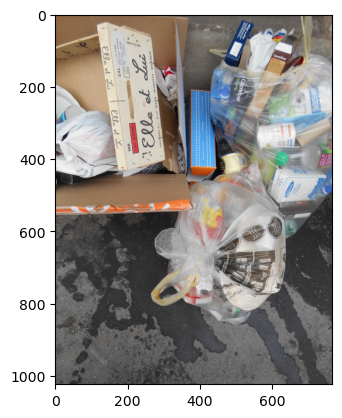

In [19]:
visualize_random_image(path=img_paths_train)

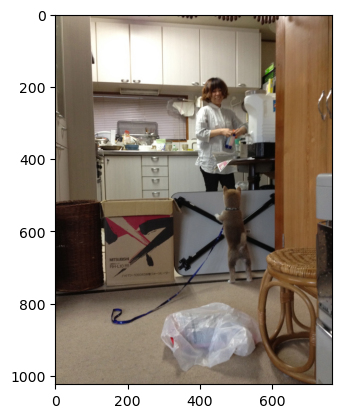

In [20]:
visualize_random_image(path=img_paths_validation)

#### Multiple images

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
                      
def visualize_many(from_num_idx, to_num_idx, path, columns = 4, rows = 5):    
    fig = plt.figure(figsize=(14, 14))
    image_paths = glob.glob(path)    
    index_counter = 1
    for i in range(from_num_idx, to_num_idx):
        counter = i
        try: 
            image = image_paths[counter]
            img = mpimg.imread(image)
            fig.add_subplot(rows, columns, index_counter)
            plt.imshow(img)
            index_counter +=1
        except: # counter is out of range of image_paths
            pass
    plt.show()

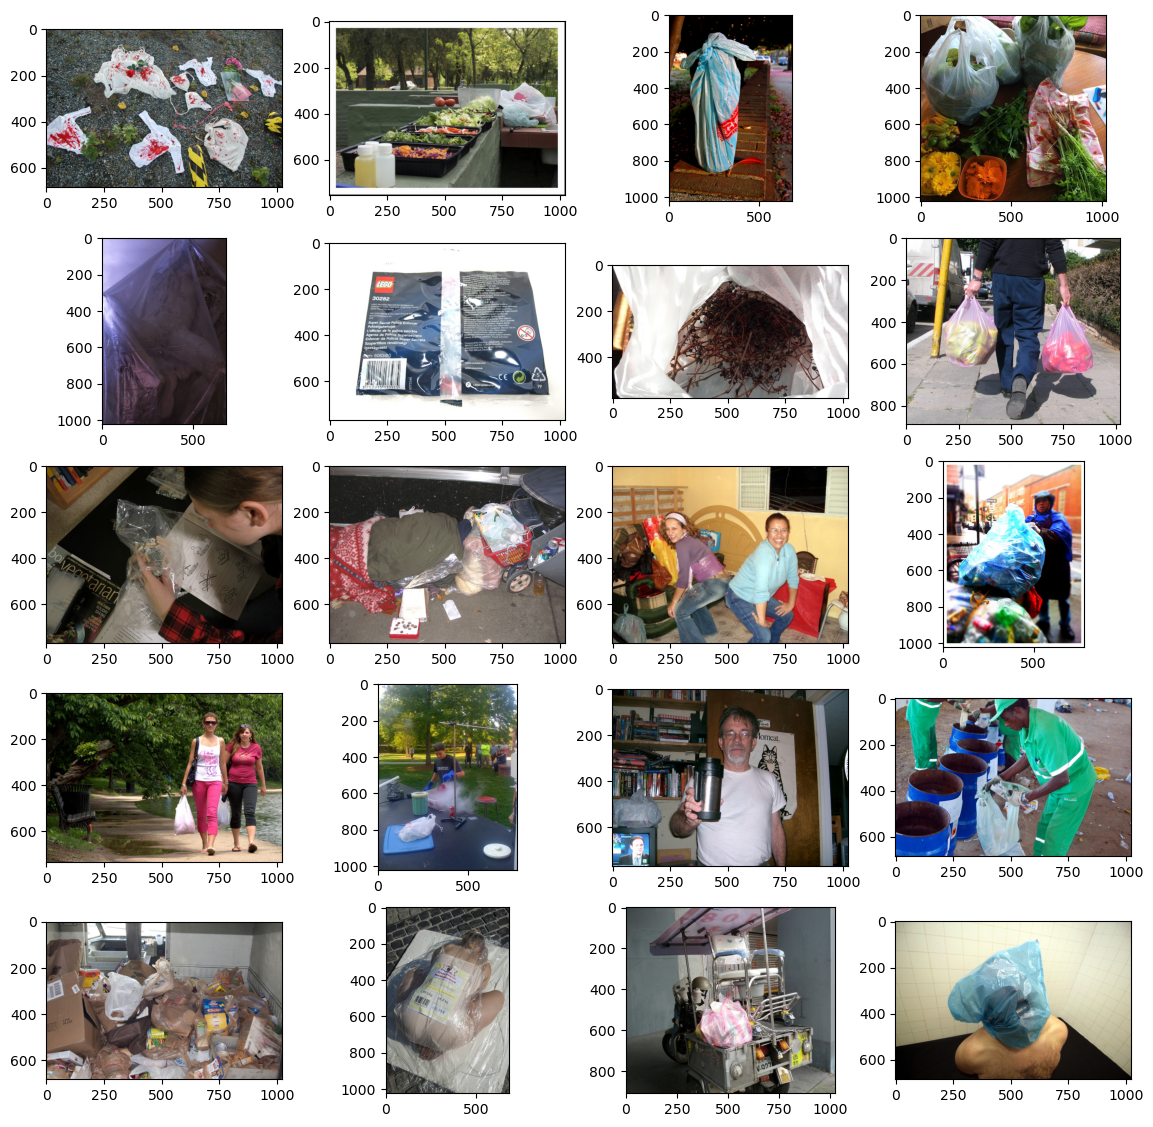

In [22]:
visualize_many(from_num_idx=10, to_num_idx=30, path=img_paths_train)

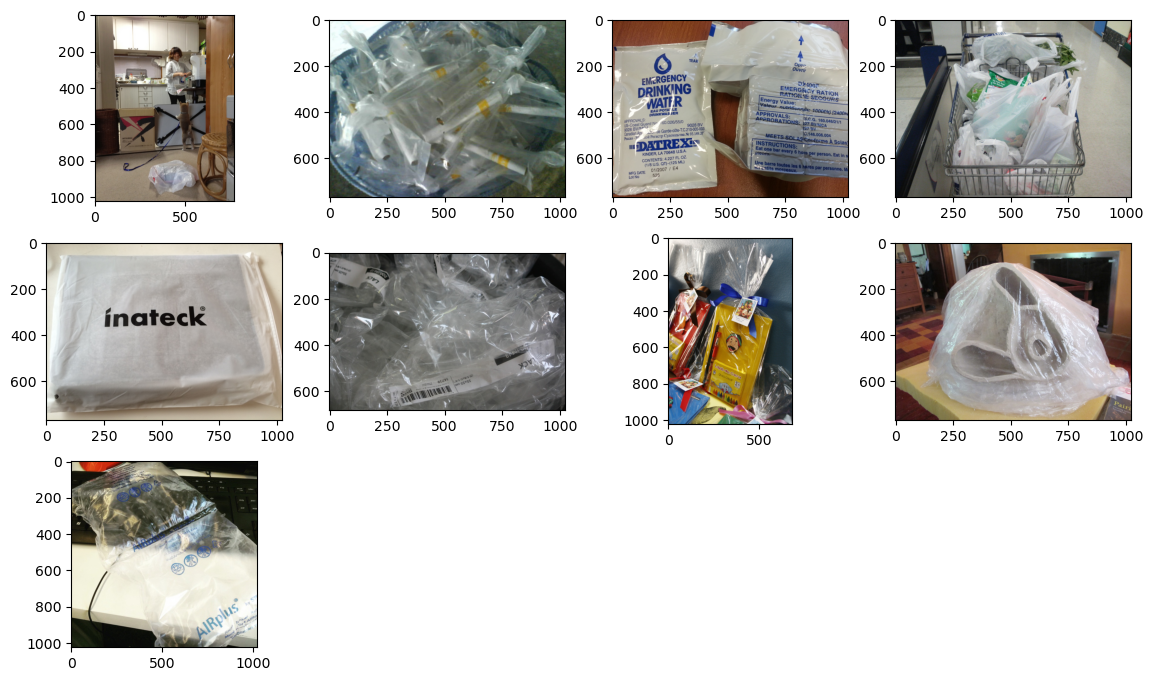

In [23]:
visualize_many(from_num_idx=0, to_num_idx=20, path=img_paths_validation)

### Visualizing Images with the Bounding Boxes

##### Eg. Image id = 4e24222b68123ef3 and label name is /m/05gqfk (Plastic bag) 

In [24]:
df_validation_1_image = df_validation.loc[(df_validation['ImageID'] == '4e24222b68123ef3') & (df_validation.LabelName == '/m/05gqfk')]
df_validation_1_image

ImageID  Source  LabelName  Confidence      XMin      XMax  \
92793  4e24222b68123ef3  xclick  /m/05gqfk           1  0.377083  0.745833   

           YMin     YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
92793  0.778125  0.96875           0            0          0            0   

       IsInside  
92793         0

768 1024


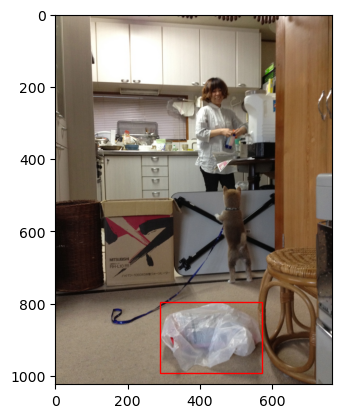

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

file_path = os.path.join(root, 'validationImages/data/4e24222b68123ef3.jpg')
img = Image.open(file_path)

fig, ax = plt.subplots()
ax.imshow(img)

# Get the image size
image_width, image_height = img.size
print(image_width, image_height) # 768 1024

# Normalization box in the detections.csv
# xmin = 0.377083
# xmax = 0.745833
# ymin = 0.778125
# ymax = 0.96875

# get new coordinates
xmin = 0.377083 * image_width  # --> xmin = 289.599
xmax = 0.745833 * image_width  # --> xmax = 572. 7997
ymin = 0.778125 * image_height # --> ymin = 796.8
ymax = 0.96875 * image_height  # --> ymax = 992.0

width = xmax - xmin
height = ymax - ymin
rect = patches.Rectangle((xmin, ymin), width, height, linewidth = 1, edgecolor = 'r', facecolor = 'none')

ax.add_patch(rect)
plt.show()

### Visualizing with multi bounding boxes

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import random
import glob
from PIL import Image

def visualize_bounding_boxes(image_paths, df): 
    image_file_paths = glob.glob(image_paths)
    num_of_images = len(image_file_paths)
    random_int = random.randint(0, num_of_images -1)
    random_image_file_path = image_file_paths[random_int]
    img = Image.open(random_image_file_path)

    id_of_image = Path(random_image_file_path).stem
    df_rows = df.loc[(df.ImageID == id_of_image) & (df.LabelName == '/m/05gqfk')]

    image_width, image_height = img.size
    fig, ax = plt.subplots()
    ax.imshow(img)

    # Run for every bounding box of an image
    for index, row in df_rows.iterrows():
        # print(row['XMin'], row['XMax'], row['YMin'], row['YMax'])

        xmin = row['XMin']
        xmax = row['XMax']
        ymin = row['YMin']
        ymax = row['YMax']

        new_xmin = xmin * image_width
        new_xmax = xmax * image_width
        new_ymin = ymin * image_height
        new_ymax = ymax * image_height
        print(new_xmin, new_xmax, new_ymin, new_ymax)

        width = new_xmax - new_xmin
        height = new_ymax - new_ymin

        rect = patches.Rectangle((new_xmin, new_ymin), width, height, linewidth = 1, edgecolor = 'r', facecolor = 'none')
        ax.add_patch(rect)
    plt.show()

0.0 73.6 307.20000000000005 431.36025600000005
0.0 1023.36 0.639744 767.360256
66.56 144.64 385.280256 417.27974399999994


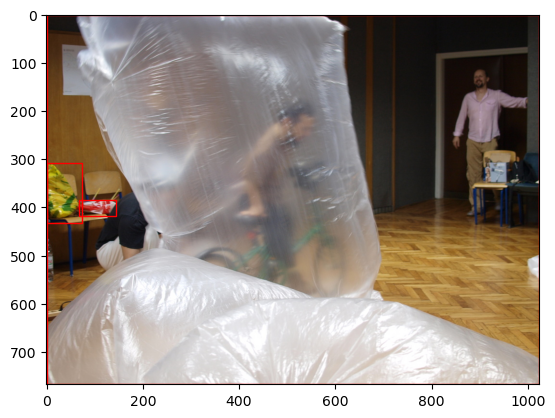

In [27]:
visualize_bounding_boxes(image_paths=img_paths_train, df=df_train)

0.0 683.0 24.16519168 1024.0


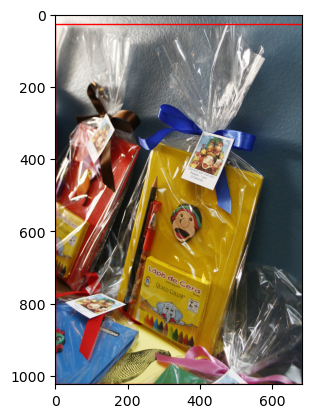

In [28]:
visualize_bounding_boxes(image_paths=img_paths_validation, df=df_validation)

## Part 2: Spliting data

### Extract Data of Plastic bag

In [29]:
def clean_dataframe(df_for_train, df_for_validation):
    df_train_cleansed = df_train[df_train['LabelName'].str.contains('/m/05gqfk')]
    df_validation_cleansed = df_validation[df_validation['LabelName'].str.contains('/m/05gqfk')]    
    return df_train_cleansed, df_validation_cleansed

df_train_cleansed, df_validation_cleansed = clean_dataframe(df_train, df_validation)

In [30]:
df_train_cleansed.shape # (986, 21) 
# we have 517 Plastic image of train data and one image may have more than
# one plastic bag bounding box --> 1 image on average has ~986/571 ~ 2 bounding boxes

(986, 21)

In [31]:
df_validation_cleansed.shape

(9, 13)

### Train and Test split

In [32]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_train_cleansed, test_size=0.2, random_state=42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [33]:
train.head()

ImageID     Source  LabelName  Confidence      XMin  \
10807483  b9176db9b1661faa     xclick  /m/05gqfk           1  0.231111   
3193099   3435faef2c5ccd6a  activemil  /m/05gqfk           1  0.005625   
13211126  e39390cebf26f22c     xclick  /m/05gqfk           1  0.213867   
6702608   711d64cd98b9be73     xclick  /m/05gqfk           1  0.000000   
5729014   60516e61f76f6ebf     xclick  /m/05gqfk           1  0.245833   

              XMax      YMin      YMax  IsOccluded  IsTruncated  ...  \
10807483  0.502222  0.540000  0.652500           0            0  ...   
3193099   0.990000  0.001667  0.995833          -1           -1  ...   
13211126  0.742188  0.101562  0.643229           0            0  ...   
6702608   0.999167  0.000000  0.998750           0            1  ...   
5729014   0.465000  0.740625  0.887500           1            0  ...   

          IsDepiction  IsInside  XClick1X  XClick2X  XClick3X  XClick4X  \
10807483            0         0  0.373333  0.231111  0.275556  0.502222   
3193099            -1        -1 -1.000000 -1.000000 -1.000000 -1.000000   
13211126            0         0  0.591797  0.256836  0.213867  0.742188   
6702608             0         0  0.348333  0.000000  0.316667  0.999167   
5729014             0         0  0.320833  0.245833  0.425833  0.465000   

          XClick1Y  XClick2Y  XClick3Y  XClick4Y  
10807483  0.540000  0.587500  0.652500  0.587500  
3193099  -1.000000 -1.000000 -1.000000 -1.000000  
13211126  0.101562  0.119792  0.643229  0.572917  
6702608   0.000000  0.831250  0.998750  0.906250  
5729014   0.740625  0.887500  0.882500  0.740625  

[5 rows x 21 columns]

In [34]:
train_ids = train["ImageID"].values.tolist()
test_ids = test["ImageID"].values.tolist()

In [35]:
len(set(train_ids).intersection(set(test_ids)))

94

In [36]:
len(train_ids)

788

In [37]:
len(test_ids)

198

In [38]:
len(train_ids) + len(test_ids)

986

### Copy images to train and test folder

In [39]:
import shutil
import glob

file_paths = glob.glob(os.path.join(root, 'trainImages/data/*.jpg'))

new_path = os.path.join(root, 'testImages/data')
if not os.path.exists(new_path):
    os.makedirs(new_path) 

for file_path in file_paths:
    id_ = Path(file_path).stem    
    
    # Note: image id is not unique for each row because one image may have several bounding boxes
    if (id_ in test_ids and id_ in train_ids):      
        shutil.copy(file_path, f"{new_path}/{id_}.jpg")        
    elif (id_ in test_ids and id_ not in train_ids):
        shutil.move(file_path, f"{new_path}/{id_}.jpg")        

In [40]:
len(glob.glob(os.path.join(root, 'trainImages/data/*.jpg')))

449

In [41]:
len(glob.glob(os.path.join(root, 'testImages/data/*.jpg')))

162

## Part 3. Data Engineering with Mxnet RecordIO format

In [42]:
# index  header_column  label_width  className  Bounding box (xmin ymin xmax ymax)          path
# 222        2              5          0.000       0.4    0.3  0.9    0.44          path/to/image11.jpg
# 222        2              5          1.000       0.5    0.2  0.33   0.8           path/to/image11.jpg

# className and 4 bounding box --> 5
# header_column is 2 because itself and the label_width

# all bounding boxes in one row: to save storage especially having a million of images
# 222    2  5  0.000  0.4  0.3  0.9  0.44  1.000 0.5 0.2 0.33 0.8  path/to/image11.jpg

In [43]:
# index  header_column label_width className xmin ymin xmax ymax path

In [44]:
train_df = train.copy()
test_df = test.copy()

In [45]:
train_df.rename(columns = {"LabelName": "className"}, inplace = True)
train_df.head()

ImageID     Source  className  Confidence      XMin  \
10807483  b9176db9b1661faa     xclick  /m/05gqfk           1  0.231111   
3193099   3435faef2c5ccd6a  activemil  /m/05gqfk           1  0.005625   
13211126  e39390cebf26f22c     xclick  /m/05gqfk           1  0.213867   
6702608   711d64cd98b9be73     xclick  /m/05gqfk           1  0.000000   
5729014   60516e61f76f6ebf     xclick  /m/05gqfk           1  0.245833   

              XMax      YMin      YMax  IsOccluded  IsTruncated  ...  \
10807483  0.502222  0.540000  0.652500           0            0  ...   
3193099   0.990000  0.001667  0.995833          -1           -1  ...   
13211126  0.742188  0.101562  0.643229           0            0  ...   
6702608   0.999167  0.000000  0.998750           0            1  ...   
5729014   0.465000  0.740625  0.887500           1            0  ...   

          IsDepiction  IsInside  XClick1X  XClick2X  XClick3X  XClick4X  \
10807483            0         0  0.373333  0.231111  0.275556  0.502222   
3193099            -1        -1 -1.000000 -1.000000 -1.000000 -1.000000   
13211126            0         0  0.591797  0.256836  0.213867  0.742188   
6702608             0         0  0.348333  0.000000  0.316667  0.999167   
5729014             0         0  0.320833  0.245833  0.425833  0.465000   

          XClick1Y  XClick2Y  XClick3Y  XClick4Y  
10807483  0.540000  0.587500  0.652500  0.587500  
3193099  -1.000000 -1.000000 -1.000000 -1.000000  
13211126  0.101562  0.119792  0.643229  0.572917  
6702608   0.000000  0.831250  0.998750  0.906250  
5729014   0.740625  0.887500  0.882500  0.740625  

[5 rows x 21 columns]

In [46]:
test_df.rename(columns = {"LabelName": "className"}, inplace = True)
test_df.head()

ImageID  Source  className  Confidence      XMin      XMax  \
8043647   888fea91e5a0e984  xclick  /m/05gqfk           1  0.293125  0.601875   
5494785   5c3a12529a5afe93  xclick  /m/05gqfk           1  0.000000  0.998438   
10048712  abd0b8f885cadc1e  xclick  /m/05gqfk           1  0.675000  0.989583   
5040124   544ee383a0319bfa  xclick  /m/05gqfk           1  0.000000  0.999375   
2147024   221dd6f9138951a7  xclick  /m/05gqfk           1  0.595625  0.766875   

              YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  \
8043647   0.196998  0.910882           1            0  ...            0   
5494785   0.233333  0.997917           1            1  ...            0   
10048712  0.580469  0.891406           1            0  ...            0   
5040124   0.000000  0.999074           1            1  ...            0   
2147024   0.431265  0.542812           1            0  ...            0   

          IsInside  XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  \
8043647          0  0.378750  0.293125  0.601875  0.423750  0.196998   
5494785          0  0.328125  0.000000  0.846875  0.998438  0.233333   
10048712         0  0.806250  0.675000  0.728125  0.989583  0.580469   
5040124          0  0.347500  0.000000  0.999375  0.891875  0.000000   
2147024          0  0.696875  0.595625  0.621875  0.766875  0.431265   

          XClick2Y  XClick3Y  XClick4Y  
8043647   0.405253  0.575985  0.910882  
5494785   0.564583  0.997917  0.497917  
10048712  0.697656  0.891406  0.860938  
5040124   0.539815  0.179630  0.999074  
2147024   0.500393  0.542812  0.500393  

[5 rows x 21 columns]

In [47]:
train_df["header_cols"] = 2
train_df["label_width"] = 5
train_df.head(3)

ImageID     Source  className  Confidence      XMin  \
10807483  b9176db9b1661faa     xclick  /m/05gqfk           1  0.231111   
3193099   3435faef2c5ccd6a  activemil  /m/05gqfk           1  0.005625   
13211126  e39390cebf26f22c     xclick  /m/05gqfk           1  0.213867   

              XMax      YMin      YMax  IsOccluded  IsTruncated  ...  \
10807483  0.502222  0.540000  0.652500           0            0  ...   
3193099   0.990000  0.001667  0.995833          -1           -1  ...   
13211126  0.742188  0.101562  0.643229           0            0  ...   

          XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  \
10807483  0.373333  0.231111  0.275556  0.502222  0.540000  0.587500   
3193099  -1.000000 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000   
13211126  0.591797  0.256836  0.213867  0.742188  0.101562  0.119792   

          XClick3Y  XClick4Y  header_cols  label_width  
10807483  0.652500  0.587500            2            5  
3193099  -1.000000 -1.000000            2            5  
13211126  0.643229  0.572917            2            5  

[3 rows x 23 columns]

In [48]:
test_df["header_cols"] = 2
test_df["label_width"] = 5
test_df.head(3)

ImageID  Source  className  Confidence      XMin      XMax  \
8043647   888fea91e5a0e984  xclick  /m/05gqfk           1  0.293125  0.601875   
5494785   5c3a12529a5afe93  xclick  /m/05gqfk           1  0.000000  0.998438   
10048712  abd0b8f885cadc1e  xclick  /m/05gqfk           1  0.675000  0.989583   

              YMin      YMax  IsOccluded  IsTruncated  ...  XClick1X  \
8043647   0.196998  0.910882           1            0  ...  0.378750   
5494785   0.233333  0.997917           1            1  ...  0.328125   
10048712  0.580469  0.891406           1            0  ...  0.806250   

          XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
8043647   0.293125  0.601875  0.423750  0.196998  0.405253  0.575985   
5494785   0.000000  0.846875  0.998438  0.233333  0.564583  0.997917   
10048712  0.675000  0.728125  0.989583  0.580469  0.697656  0.891406   

          XClick4Y  header_cols  label_width  
8043647   0.910882            2            5  
5494785   0.497917            2            5  
10048712  0.860938            2            5  

[3 rows x 23 columns]

### Create image path: 001.Plastic_bag/images/...

In [49]:
train_df["ImagePath"] = "001.Plastic_bag/images/train/" + train_df['ImageID'] + '.jpg'
test_df["ImagePath"] = "001.Plastic_bag/images/test/" + test_df['ImageID']+ '.jpg'
train_df.head()

ImageID     Source  className  Confidence      XMin  \
10807483  b9176db9b1661faa     xclick  /m/05gqfk           1  0.231111   
3193099   3435faef2c5ccd6a  activemil  /m/05gqfk           1  0.005625   
13211126  e39390cebf26f22c     xclick  /m/05gqfk           1  0.213867   
6702608   711d64cd98b9be73     xclick  /m/05gqfk           1  0.000000   
5729014   60516e61f76f6ebf     xclick  /m/05gqfk           1  0.245833   

              XMax      YMin      YMax  IsOccluded  IsTruncated  ...  \
10807483  0.502222  0.540000  0.652500           0            0  ...   
3193099   0.990000  0.001667  0.995833          -1           -1  ...   
13211126  0.742188  0.101562  0.643229           0            0  ...   
6702608   0.999167  0.000000  0.998750           0            1  ...   
5729014   0.465000  0.740625  0.887500           1            0  ...   

          XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
10807483  0.231111  0.275556  0.502222  0.540000  0.587500  0.652500   
3193099  -1.000000 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000   
13211126  0.256836  0.213867  0.742188  0.101562  0.119792  0.643229   
6702608   0.000000  0.316667  0.999167  0.000000  0.831250  0.998750   
5729014   0.245833  0.425833  0.465000  0.740625  0.887500  0.882500   

          XClick4Y  header_cols  label_width  \
10807483  0.587500            2            5   
3193099  -1.000000            2            5   
13211126  0.572917            2            5   
6702608   0.906250            2            5   
5729014   0.740625            2            5   

                                                  ImagePath  
10807483  001.Plastic_bag/images/train/b9176db9b1661faa.jpg  
3193099   001.Plastic_bag/images/train/3435faef2c5ccd6a.jpg  
13211126  001.Plastic_bag/images/train/e39390cebf26f22c.jpg  
6702608   001.Plastic_bag/images/train/711d64cd98b9be73.jpg  
5729014   001.Plastic_bag/images/train/60516e61f76f6ebf.jpg  

[5 rows x 24 columns]

In [50]:
test_df.head(3)

ImageID  Source  className  Confidence      XMin      XMax  \
8043647   888fea91e5a0e984  xclick  /m/05gqfk           1  0.293125  0.601875   
5494785   5c3a12529a5afe93  xclick  /m/05gqfk           1  0.000000  0.998438   
10048712  abd0b8f885cadc1e  xclick  /m/05gqfk           1  0.675000  0.989583   

              YMin      YMax  IsOccluded  IsTruncated  ...  XClick2X  \
8043647   0.196998  0.910882           1            0  ...  0.293125   
5494785   0.233333  0.997917           1            1  ...  0.000000   
10048712  0.580469  0.891406           1            0  ...  0.675000   

          XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  XClick4Y  \
8043647   0.601875  0.423750  0.196998  0.405253  0.575985  0.910882   
5494785   0.846875  0.998438  0.233333  0.564583  0.997917  0.497917   
10048712  0.728125  0.989583  0.580469  0.697656  0.891406  0.860938   

          header_cols  label_width  \
8043647             2            5   
5494785             2            5   
10048712            2            5   

                                                 ImagePath  
8043647   001.Plastic_bag/images/test/888fea91e5a0e984.jpg  
5494785   001.Plastic_bag/images/test/5c3a12529a5afe93.jpg  
10048712  001.Plastic_bag/images/test/abd0b8f885cadc1e.jpg  

[3 rows x 24 columns]

### Get needed columns in an order

In [51]:
train_df = train_df[['header_cols', 'label_width', 'className', 'XMin', 'YMin', 'XMax', 'YMax', 'ImagePath']]
test_df = test_df[['header_cols', 'label_width', 'className', 'XMin', 'YMin', 'XMax', 'YMax', 'ImagePath']]
train_df.head(3)

header_cols  label_width  className      XMin      YMin      XMax  \
10807483            2            5  /m/05gqfk  0.231111  0.540000  0.502222   
3193099             2            5  /m/05gqfk  0.005625  0.001667  0.990000   
13211126            2            5  /m/05gqfk  0.213867  0.101562  0.742188   

              YMax                                          ImagePath  
10807483  0.652500  001.Plastic_bag/images/train/b9176db9b1661faa.jpg  
3193099   0.995833  001.Plastic_bag/images/train/3435faef2c5ccd6a.jpg  
13211126  0.643229  001.Plastic_bag/images/train/e39390cebf26f22c.jpg

In [52]:
test_df.head(3)

header_cols  label_width  className      XMin      YMin      XMax  \
8043647             2            5  /m/05gqfk  0.293125  0.196998  0.601875   
5494785             2            5  /m/05gqfk  0.000000  0.233333  0.998438   
10048712            2            5  /m/05gqfk  0.675000  0.580469  0.989583   

              YMax                                         ImagePath  
8043647   0.910882  001.Plastic_bag/images/test/888fea91e5a0e984.jpg  
5494785   0.997917  001.Plastic_bag/images/test/5c3a12529a5afe93.jpg  
10048712  0.891406  001.Plastic_bag/images/test/abd0b8f885cadc1e.jpg

### Change value of className = 0.000 for "/m/05gqfk" (Plasic bag) class

In [53]:
final_train_df = train_df.copy()
final_train_df['className'] = "0.000"
final_train_df

header_cols  label_width className      XMin      YMin      XMax  \
10807483            2            5     0.000  0.231111  0.540000  0.502222   
3193099             2            5     0.000  0.005625  0.001667  0.990000   
13211126            2            5     0.000  0.213867  0.101562  0.742188   
6702608             2            5     0.000  0.000000  0.000000  0.999167   
5729014             2            5     0.000  0.245833  0.740625  0.465000   
...               ...          ...       ...       ...       ...       ...   
436203              2            5     0.000  0.222656  0.203125  0.994531   
2105961             2            5     0.000  0.552500  0.429167  0.796250   
12289483            2            5     0.000  0.486250  0.450281  0.693750   
5017725             2            5     0.000  0.378019  0.048128  0.983092   
423059              2            5     0.000  0.261250  0.131653  0.999375   

              YMax                                          ImagePath  
10807483  0.652500  001.Plastic_bag/images/train/b9176db9b1661faa.jpg  
3193099   0.995833  001.Plastic_bag/images/train/3435faef2c5ccd6a.jpg  
13211126  0.643229  001.Plastic_bag/images/train/e39390cebf26f22c.jpg  
6702608   0.998750  001.Plastic_bag/images/train/711d64cd98b9be73.jpg  
5729014   0.887500  001.Plastic_bag/images/train/60516e61f76f6ebf.jpg  
...            ...                                                ...  
436203    0.970833  001.Plastic_bag/images/train/05642dbfac7ae5b0.jpg  
2105961   0.721667  001.Plastic_bag/images/train/216da3e31dfbb78d.jpg  
12289483  0.999062  001.Plastic_bag/images/train/d2e1237d3c2846e9.jpg  
5017725   0.907308  001.Plastic_bag/images/train/53ef69782bdc1d63.jpg  
423059    0.999066  001.Plastic_bag/images/train/05307e6f3f7d7daf.jpg  

[788 rows x 8 columns]

In [54]:
final_test_df = test_df.copy()
final_test_df['className'] = "0.000"
final_test_df

header_cols  label_width className      XMin      YMin      XMax  \
8043647             2            5     0.000  0.293125  0.196998  0.601875   
5494785             2            5     0.000  0.000000  0.233333  0.998438   
10048712            2            5     0.000  0.675000  0.580469  0.989583   
5040124             2            5     0.000  0.000000  0.000000  0.999375   
2147024             2            5     0.000  0.595625  0.431265  0.766875   
...               ...          ...       ...       ...       ...       ...   
1104154             2            5     0.000  0.528125  0.613333  0.662500   
5995456             2            5     0.000  0.683750  0.000000  0.998750   
135411              2            5     0.000  0.306836  0.152500  0.998410   
9872849             2            5     0.000  0.125000  0.466250  0.181667   
14145224            2            5     0.000  0.527500  0.410000  0.905000   

              YMax                                         ImagePath  
8043647   0.910882  001.Plastic_bag/images/test/888fea91e5a0e984.jpg  
5494785   0.997917  001.Plastic_bag/images/test/5c3a12529a5afe93.jpg  
10048712  0.891406  001.Plastic_bag/images/test/abd0b8f885cadc1e.jpg  
5040124   0.999074  001.Plastic_bag/images/test/544ee383a0319bfa.jpg  
2147024   0.542812  001.Plastic_bag/images/test/221dd6f9138951a7.jpg  
...            ...                                               ...  
1104154   0.728333  001.Plastic_bag/images/test/102e5834dbf0b1cc.jpg  
5995456   0.335000  001.Plastic_bag/images/test/64f1b54aa2f25853.jpg  
135411    0.998750  001.Plastic_bag/images/test/011c2e4461eb1fdc.jpg  
9872849   0.661250  001.Plastic_bag/images/test/a8b17d203d9eea1a.jpg  
14145224  0.980000  001.Plastic_bag/images/test/f6a61b3b167cbbbc.jpg  

[198 rows x 8 columns]

### Moving images to 001.Plastic_bag/images/...

In [55]:
import shutil
import os

shutil.move(os.path.join(root, 'trainImages/data'), os.path.join(root, '001.Plastic_bag/images/train'))

'unzipped/001.Plastic_bag/images/train'

In [56]:
shutil.move(os.path.join(root, 'testImages/data'), os.path.join(root, '001.Plastic_bag/images/test'))

'unzipped/001.Plastic_bag/images/test'

In [57]:
len(glob.glob(os.path.join(root, '001.Plastic_bag/images/train/*.jpg')))

449

In [58]:
len(glob.glob(os.path.join(root, '001.Plastic_bag/images/test/*.jpg')))

162

### Creating production .lts files  
If we want to store one image data (with one or more bounding boxes) in one row --> do some data manipulation.
Below is an example code to do it.

In [59]:
test_file_paths = final_test_df['ImagePath'].tolist()
len(test_file_paths)

198

In [60]:
test_file_paths[9] # this '001.Plastic_bag/images/test/614a6b3531b9f0dc.jpg' has 5 bounding boxes

'001.Plastic_bag/images/test/614a6b3531b9f0dc.jpg'

In [61]:
image_file_path = test_file_paths[9]
df_row = final_test_df.loc[final_test_df['ImagePath'] == image_file_path ]
df_row

header_cols  label_width className      XMin      YMin      XMax  \
5784402            2            5     0.000  0.365000  0.324167  0.438750   
5784394            2            5     0.000  0.155625  0.455000  0.304375   
5784401            2            5     0.000  0.333750  0.513333  0.426875   
5784398            2            5     0.000  0.231875  0.360000  0.350625   
5784393            2            5     0.000  0.151875  0.220833  0.295000   

             YMax                                         ImagePath  
5784402  0.417500  001.Plastic_bag/images/test/614a6b3531b9f0dc.jpg  
5784394  0.563333  001.Plastic_bag/images/test/614a6b3531b9f0dc.jpg  
5784401  0.650000  001.Plastic_bag/images/test/614a6b3531b9f0dc.jpg  
5784398  0.517500  001.Plastic_bag/images/test/614a6b3531b9f0dc.jpg  
5784393  0.367500  001.Plastic_bag/images/test/614a6b3531b9f0dc.jpg

In [62]:
import csv
import random

final = []
idx = 0
for file_path in test_file_paths:    
    df_rows = final_test_df.loc[final_test_df['ImagePath'] == file_path]
    
    im_path = df_rows.loc[df_rows.index[0]]['ImagePath'] 
    length = len(df_rows)
    count = 1
    arr = [idx, 2, 5]
    
    for index, row in df_rows.iterrows():
        xmin = str(row['XMin'])
        ymin = str(row['YMin'])
        xmax = str(row['XMax'])
        ymax = str(row['YMax'])
             
        arr.extend(["0.000", xmin, ymin, xmax, ymax]) # className for Plastic bag is "0.000"        
        if count == length:
            arr.append(im_path)
        count += 1
        
    idx += 1        
    final.append(arr)    
    
with open(os.path.join(root, 'test.lst'), 'w', newline = '') as f:
    for row in final:
        writer = csv.writer(f, delimiter = '\t')
        writer.writerow(row)